# [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge)
Can you automatically suggest product prices to online sellers?

# Import packages

In [5]:
import pandas as pd #data processing
import numpy as np #linear algebra
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline
import matplotlib.pyplot as plt #commonly used visualization tool
import seaborn as sns #new visualization tool
from string import ascii_letters
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV #hyper-parameter tuning
from sklearn.ensemble import RandomForestRegressor

# Import data

set train and test data, split by tab because of the tsv format.

In [9]:
%%time
train_df = pd.read_csv("data/train.tsv", delimiter='\t', low_memory= True)
test_df = pd.read_csv("data/test.tsv", delimiter='\t', low_memory= True)

CPU times: user 6.91 s, sys: 637 ms, total: 7.55 s
Wall time: 6.75 s


In [12]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [11]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

### converting column types

In [27]:
print(train_df.dtypes)
print("------------")
print(test_df.dtypes)

train_id               int64
name                  object
item_condition_id      int32
category_name         object
brand_name            object
price                float64
shipping                int8
item_description      object
dtype: object
------------
test_id               int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object


In [28]:
train_df["item_condition_id"] = train_df["item_condition_id"].astype("int32")
train_df["shipping"] = train_df["shipping"].astype("int8")

test_df["item_condition_id"] = test_df["item_condition_id"].astype("int32")
test_df["shipping"] = test_df["shipping"].astype("int8")

In [29]:
print(train_df.dtypes)
print("------------")
print(test_df.dtypes)

train_id               int64
name                  object
item_condition_id      int32
category_name         object
brand_name            object
price                float64
shipping                int8
item_description      object
dtype: object
------------
test_id               int64
name                 object
item_condition_id     int32
category_name        object
brand_name           object
shipping               int8
item_description     object
dtype: object


do a little exploring on discriptive statistics

In [30]:
pd.set_option('float_format', '{:f}'.format)
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1482535.000000,1482535.000000,1482535.000000,1482535.000000
mean,741267.000000,1.907380,26.737516,0.447274
std,427971.135004,0.903159,38.586066,0.497212
min,0.000000,1.000000,0.000000,0.000000
25%,370633.500000,1.000000,10.000000,0.000000
50%,741267.000000,2.000000,17.000000,0.000000
75%,1111900.500000,3.000000,29.000000,1.000000
max,1482534.000000,5.000000,2009.000000,1.000000


checking individual values

In [31]:
train_df.apply(lambda x: x.nunique())

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64

# data preprocessing

### checking missing values

found missing values in category_name, brand_name, and item_discription

In [33]:
print(train_df.isnull().sum()[train_df.isnull().sum() != 0])
print("------------")
print(test_df.isnull().sum()[test_df.isnull().sum() != 0])

category_name         6327
brand_name          632682
item_description         4
dtype: int64
------------
category_name      3058
brand_name       295525
dtype: int64


- Fill products with no brand name with 'NoBrand'
- Fill products with no category name with 'No/No/No'
- Fill products with no item descriptions with 'No description yet' (same as the first data)

In [34]:
train_df["brand_name"] = train_df["brand_name"].fillna("NoBrand")
test_df["brand_name"] = test_df["brand_name"].fillna("NoBrand")

train_df["category_name"] = train_df["category_name"].fillna("No/No/No")
test_df["category_name"] = test_df["category_name"].fillna("No/No/No")

train_df["item_description"] = train_df["item_description"].fillna("No description yet")

In [35]:
print(train_df.isnull().sum()[train_df.isnull().sum() != 0])
print("------------")
print(test_df.isnull().sum()[test_df.isnull().sum() != 0])

Series([], dtype: int64)
------------
Series([], dtype: int64)


extracting data from category_name, brand_name, and item_discription

In [101]:
def split(txt):
    try :
        return txt.split("/")
    except :
        return ("No Label", "No Label", "No Label")
    
train_df['general_category']='' 
train_df['subcategory_1'] = '' 
train_df['subcategory_2'] = ''

# zip to make it work faster and so does lambda
train_df['general_category'],train_df['subcategory_1'],train_df['subcategory_2'] = \
zip(*train_df['category_name'].apply(lambda x: split(x)))

In [102]:
test_df['general_category'],test_df['subcategory_1'],test_df['subcategory_2'] = \
zip(*test_df['category_name'].apply(lambda x: split(x)))

再次觀看資料項目

In [103]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_category,subcategory_1,subcategory_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NoBrand,10.000000,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.000000,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.000000,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NoBrand,35.000000,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NoBrand,44.000000,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


再次確認空值

In [104]:
print(pd.isnull(train_df).sum())
print("------------")
print(pd.isnull(test_df).sum())

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
general_category     0
subcategory_1        0
subcategory_2        0
dtype: int64
------------
test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
general_category     0
subcategory_1        0
subcategory_2        0
dtype: int64


回傳列數與欄數

In [105]:
print('Train shape:{}\nTest shape:{}'.format(train_df.shape, test_df.shape))

Train shape:(1482535, 11)
Test shape:(693359, 10)


In [106]:
pd.set_option('float_format', '{:f}'.format)
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1482535.000000,1482535.000000,1482535.000000,1482535.000000
mean,741267.000000,1.907380,26.737516,0.447274
std,427971.135004,0.903159,38.586066,0.497212
min,0.000000,1.000000,0.000000,0.000000
25%,370633.500000,1.000000,10.000000,0.000000
50%,741267.000000,2.000000,17.000000,0.000000
75%,1111900.500000,3.000000,29.000000,1.000000
max,1482534.000000,5.000000,2009.000000,1.000000


# EDA

用plt做hist，觀察出price大部分小於50

Text(0.5, 1.0, 'Price Distribution')

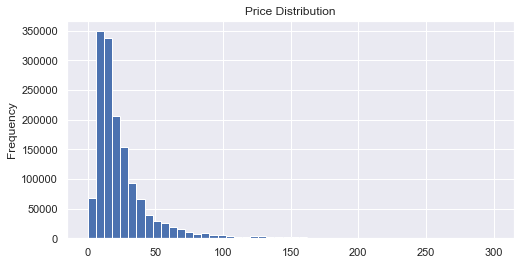

In [107]:
train_df.price.plot.hist(bins=50, figsize=(8,4), edgecolor='white',range=[0,300])
plt.title('Price Distribution')

Text(0.5, 1.0, 'Price Distribution (log price +1 )')

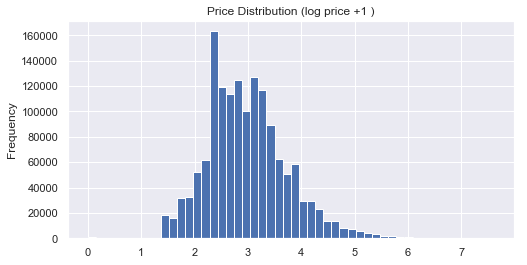

In [108]:
np.log(train_df['price']+1).plot.hist(bins=50, figsize=(8,4), edgecolor='white')
plt.title('Price Distribution (log price +1 )')

price本身平均在30，中位數20
<br>這告訴我們訂價大部分介於100以內，但還是有到2009的

In [109]:
train_df['price'].describe()

count   1482535.000000
mean         26.737516
std          38.586066
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2009.000000
Name: price, dtype: float64

用seaborn原本要用出個別表格，沒分割的結果...

Text(0.5, 1.0, 'Count of each general category')

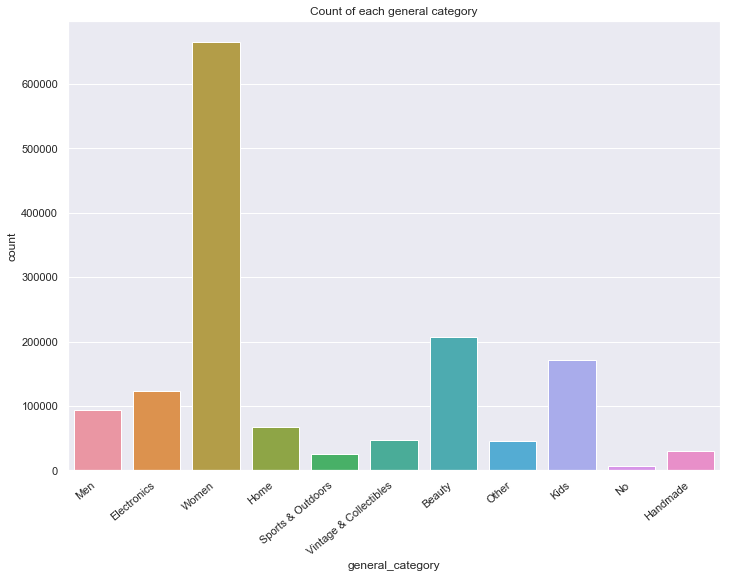

In [110]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.countplot('general_category',data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of each general category')

大部分狀態1到3

Text(0.5, 1.0, 'Count of each item condition')

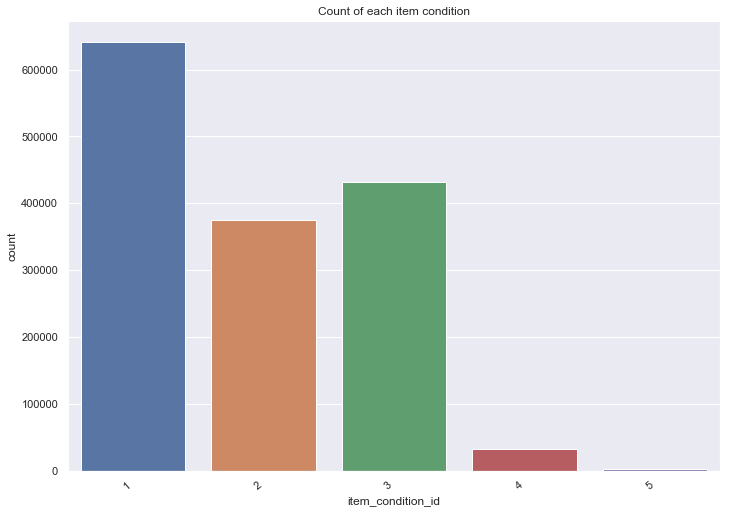

In [111]:
ax = sns.countplot('item_condition_id',data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of each item condition')

Text(0.5, 1.0, 'Count of each item condition by general category')

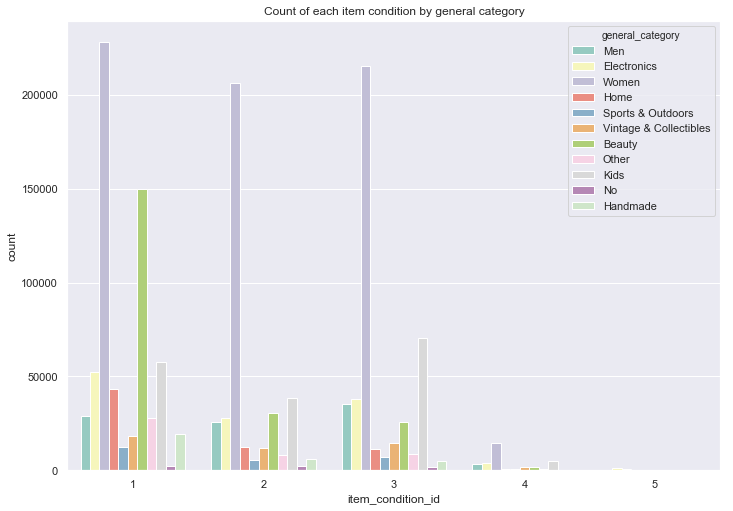

In [112]:
ax = sns.countplot(x="item_condition_id", hue="general_category", data=train_df, palette="Set3")
ax.set_title('Count of each item condition by general category')

突然想算個Pearson相關係數

In [113]:
train_df.corr()

,train_id,item_condition_id,price,shipping
train_id,1.000000,-0.000113,0.000478,0.000472
item_condition_id,-0.000113,1.000000,-0.000807,-0.191154
price,0.000478,-0.000807,1.000000,-0.097211
shipping,0.000472,-0.191154,-0.097211,1.000000


Kendall Tau相關係數

In [114]:
train_df.corr('kendall')

,train_id,item_condition_id,price,shipping
train_id,1.000000,-0.000125,0.000579,0.000386
item_condition_id,-0.000125,1.000000,-0.006968,-0.185219
price,0.000579,-0.006968,1.000000,-0.198605
shipping,0.000386,-0.185219,-0.198605,1.000000


Spearman相關係數

In [115]:
train_df.corr('spearman')

,train_id,item_condition_id,price,shipping
train_id,1.000000,-0.000164,0.000857,0.000472
item_condition_id,-0.000164,1.000000,-0.008644,-0.197198
price,0.000857,-0.008644,1.000000,-0.239887
shipping,0.000472,-0.197198,-0.239887,1.000000


In [116]:
print(train_df['brand_name'].nunique())

4810


In [117]:
train_df.brand_name.value_counts()[:10]

NoBrand              632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Apple                 17322
FOREVER 21            15186
Nintendo              15007
Lululemon             14558
Michael Kors          13928
Name: brand_name, dtype: int64

展示個文字雲，這是item_description的

(-0.5, 1439.5, 1079.5, -0.5)

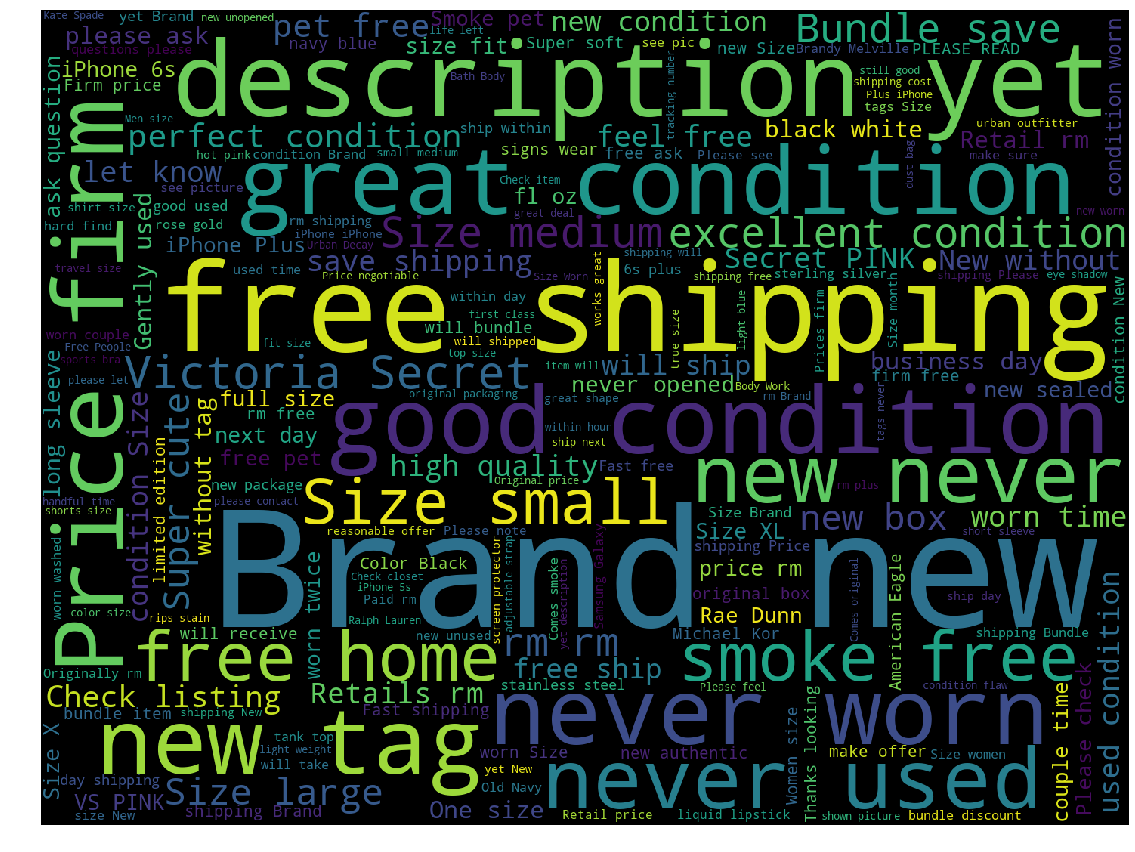

In [118]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_df['item_description']
.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

再做一個category_name的

(-0.5, 1439.5, 1079.5, -0.5)

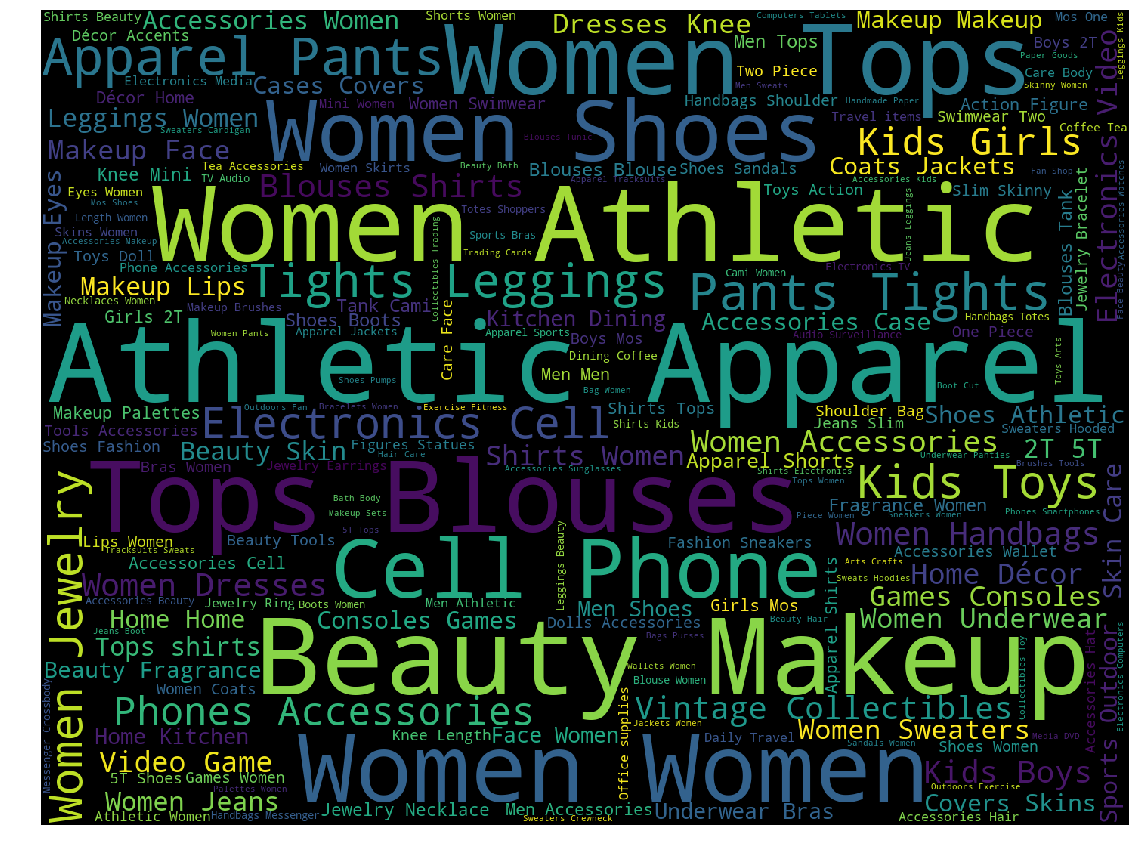

In [119]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_df['category_name']
.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

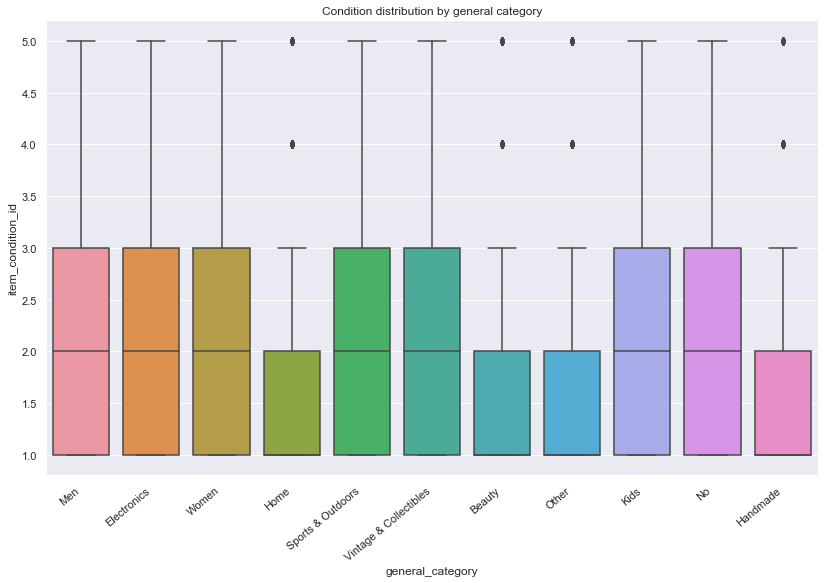

In [120]:
ax = sns.boxplot(x="general_category", y="item_condition_id", data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Condition distribution by general category')

plt.tight_layout()

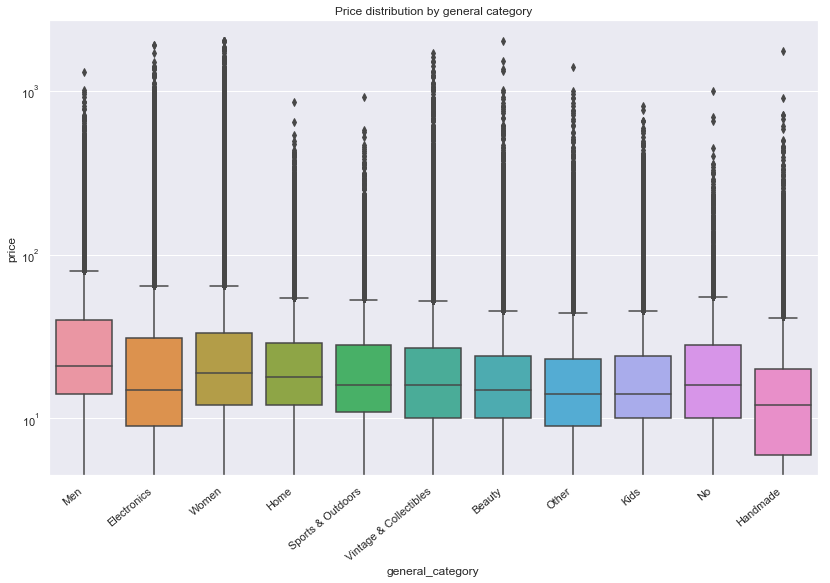

In [121]:
ax = sns.boxplot(x="general_category", y="price", data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_yscale('log')
ax.set_title('Price distribution by general category')

plt.tight_layout()

Text(0.5, 1.0, 'Count of shipping by general category')

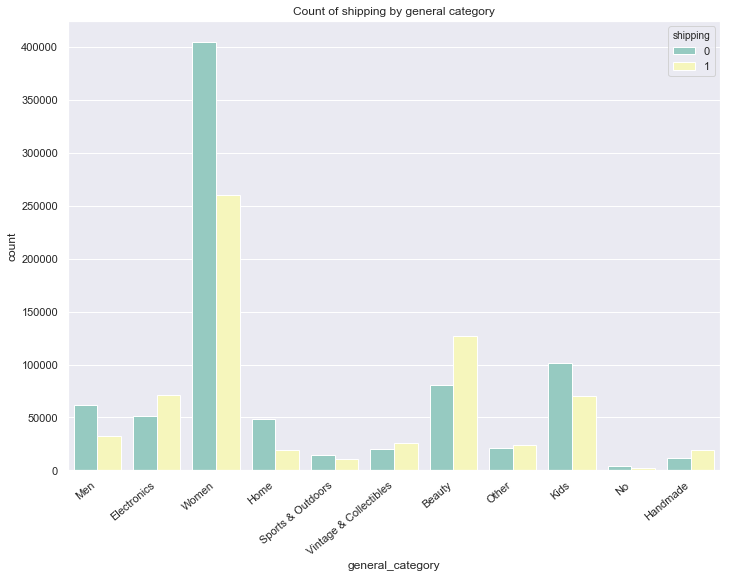

In [122]:
ax = sns.countplot(x="general_category", hue="shipping", data=train_df, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of shipping by general category')

Text(0.5, 1.0, 'Price distribution by shipping')

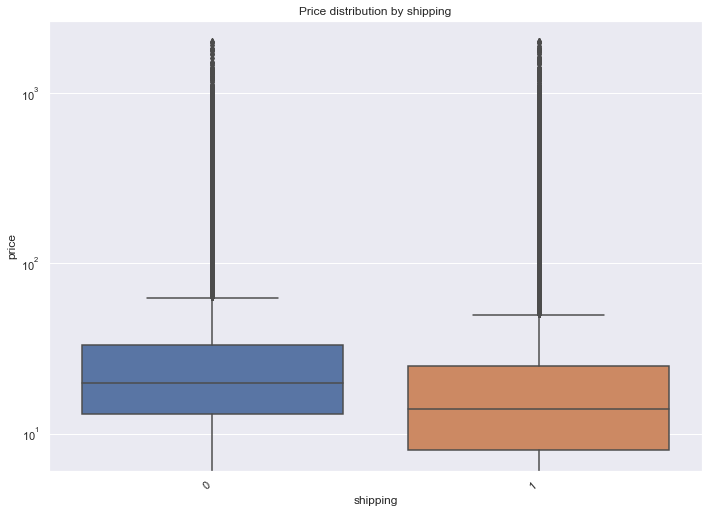

In [123]:
ax = sns.boxplot(x="shipping", y="price", data=train_df)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Price distribution by shipping')

Text(0.5, 1.0, 'Price distribution by general category and shipping')

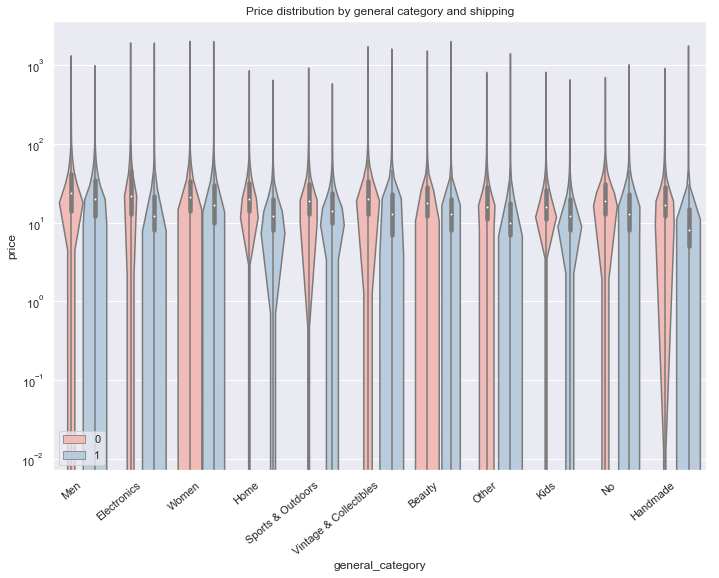

In [124]:
ax = sns.violinplot(x='general_category', y='price', hue='shipping', data=train_df, palette="Pastel1",legend_out=False)
plt.legend(loc='lower left')
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Price distribution by general category and shipping')

In [125]:
print(train_df.groupby(['subcategory_1'])["price"].mean().sort_values(ascending=False)[:10])
print("------------")
print(train_df.groupby(['subcategory_2'])["price"].mean().sort_values(ascending=False)[:10])

subcategory_1
Computers & Tablets        87.887754
Cameras & Photography      71.343813
Strollers                  67.280922
Bags and Purses            61.790944
Women's Handbags           58.201648
Musical instruments        46.684109
TV, Audio & Surveillance   44.159542
Footwear                   42.998148
Shoes                      41.811223
Golf                       41.606742
Name: price, dtype: float64
------------
subcategory_2
Laptops & Netbooks          177.089176
Standard                    163.666667
Desktops & All-In-Ones      149.329412
Handbag                     139.562546
Travel Systems              124.600000
Air Conditioners            121.142857
Lightweight                 117.111111
Digital Cameras             112.305349
Satchel                     111.624518
Cell Phones & Smartphones   109.109508
Name: price, dtype: float64


In [126]:
train_df.groupby(['brand_name'])["price"].mean().sort_values(ascending=False)[:10]

brand_name
Demdaco            429.000000
Proenza Schouler   413.250000
Auto Meter         344.000000
Oris               300.000000
MCM Worldwide      289.173913
Longines           254.000000
Vitamix            253.111111
Blendtec           251.800000
David Yurman       248.611570
Celine             238.780822
Name: price, dtype: float64

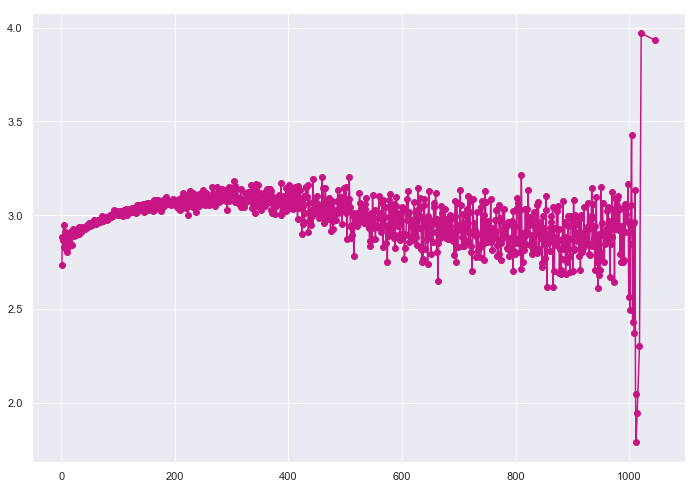

In [127]:
train_df.item_description = train_df.item_description.fillna('Empty')
train_df['log_price'] = np.log(train_df['price']+1)

train_df['des_len'] = train_df.item_description.apply(lambda x : len(x))

df = train_df.groupby(['des_len'])['log_price'].mean().reset_index()

plt.plot('des_len','log_price', data=df, marker='o', color='mediumvioletred')

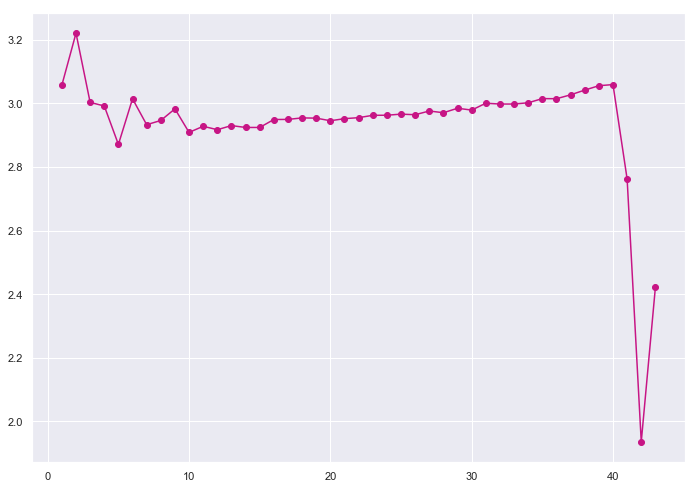

In [128]:
train_df['name_len'] = train_df.name.apply(lambda x : len(x))

df = train_df.groupby(['name_len'])['log_price'].mean().reset_index()

plt.plot('name_len','log_price', data=df, marker='o', color='mediumvioletred')

In [129]:
test_df['des_len'] = test_df.item_description.apply(lambda x : len(x))
test_df['name_len'] = test_df.name.apply(lambda x : len(x))
#test_df['log_price'] = np.log(test_df['price']+1)

# modeling

先把id改好，改成統一

In [137]:
train_df = train_df.rename(columns = {'train_id' : 'id'})
test_df = test_df.rename(columns = {"test_id" : "id"})

要把test and train dataset combine

In [138]:
train_df['is_train'] = 1
test_df['is_train'] = 0 

利用pd.concat，不包含price

In [139]:
y_train = train_df.price
train_test_combine = pd.concat([train_df.drop(['price'] , axis = 1) , test_df], axis = 0)

C:\Users\Jack Chang\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [140]:
train_test_combine.head()

,brand_name,category_name,des_len,general_category,id,is_train,item_condition_id,item_description,log_price,name,name_len,shipping,subcategory_1,subcategory_2
0,NoBrand,Men/Tops/T-shirts,18,Men,0,1,3,No description yet,2.397895,MLB Cincinnati Reds T Shirt Size XL,35,1,Tops,T-shirts
1,Razer,Electronics/Computers & Tablets/Components & P...,188,Electronics,1,1,3,This keyboard is in great condition and works ...,3.970292,Razer BlackWidow Chroma Keyboard,32,0,Computers & Tablets,Components & Parts
2,Target,Women/Tops & Blouses/Blouse,124,Women,2,1,1,Adorable top with a hint of lace and a key hol...,2.397895,AVA-VIV Blouse,14,1,Tops & Blouses,Blouse
3,NoBrand,Home/Home Décor/Home Décor Accents,173,Home,3,1,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Leather Horse Statues,21,1,Home Décor,Home Décor Accents
4,NoBrand,Women/Jewelry/Necklaces,41,Women,4,1,1,Complete with certificate of authenticity,3.806662,24K GOLD plated rose,20,0,Jewelry,Necklaces


Convert string to category

In [141]:
train_test_combine.category_name = train_test_combine.category_name.astype('category')
train_test_combine.item_description = train_test_combine.item_description.astype('category')
train_test_combine.name = train_test_combine.name.astype('category')
train_test_combine.brand_name = train_test_combine.brand_name.astype('category')
train_test_combine.general_category = train_test_combine.general_category.astype('category')
train_test_combine.subcategory_1 = train_test_combine.subcategory_1.astype('category')
train_test_combine.subcategory_2 = train_test_combine.subcategory_2.astype('category')

cat.codes提取底層整數的方法

In [142]:
train_test_combine.name = train_test_combine.name.cat.codes
train_test_combine.brand_name = train_test_combine.brand_name.cat.codes
train_test_combine.item_description = train_test_combine.item_description.cat.codes
train_test_combine.category_name = train_test_combine.category_name.cat.codes
train_test_combine.general_category = train_test_combine.general_category.cat.codes
train_test_combine.subcategory_1 = train_test_combine.subcategory_1.cat.codes
train_test_combine.subcategory_2 = train_test_combine.subcategory_2.cat.codes

In [143]:
train_test_combine.head()

,brand_name,category_name,des_len,general_category,id,is_train,item_condition_id,item_description,log_price,name,name_len,shipping,subcategory_1,subcategory_2
0,3357,829,18,5,0,1,3,1172053,2.397895,916335,35,1,103,774
1,3890,86,188,1,1,1,3,1585539,3.970292,1292428,32,0,30,215
2,4589,1278,124,10,2,1,1,167133,2.397895,131013,14,1,104,97
3,3357,503,173,3,3,1,1,1136643,3.583519,802671,21,1,55,410
4,3357,1205,41,10,4,1,1,531909,3.806662,65051,20,0,58,542


In [144]:
print(pd.isnull(train_test_combine).sum())

brand_name                0
category_name             0
des_len                   0
general_category          0
id                        0
is_train                  0
item_condition_id         0
item_description          0
log_price            693359
name                      0
name_len                  0
shipping                  0
subcategory_1             0
subcategory_2             0
dtype: int64


In [145]:
columns = ['log_price']
train_test_combine.drop(columns, inplace=True, axis=1)

成功轉換

In [146]:
train_test_combine.dtypes

brand_name           int16
category_name        int16
des_len              int64
general_category      int8
id                   int64
is_train             int64
item_condition_id    int32
item_description     int32
name                 int32
name_len             int64
shipping              int8
subcategory_1         int8
subcategory_2        int16
dtype: object

再把他分開

In [147]:
train_df = train_test_combine.loc[train_test_combine['is_train'] == 1]
test_df = train_test_combine.loc[train_test_combine['is_train'] == 0]

In [148]:
train_df = train_df.drop(['is_train'] , axis = 1)
test_df = test_df.drop(['is_train'] , axis = 1)

In [149]:
train_df.head()

,brand_name,category_name,des_len,general_category,id,item_condition_id,item_description,name,name_len,shipping,subcategory_1,subcategory_2
0,3357,829,18,5,0,3,1172053,916335,35,1,103,774
1,3890,86,188,1,1,3,1585539,1292428,32,0,30,215
2,4589,1278,124,10,2,1,167133,131013,14,1,104,97
3,3357,503,173,3,3,1,1136643,802671,21,1,55,410
4,3357,1205,41,10,4,1,531909,65051,20,0,58,542


In [150]:
test_df.head()

,brand_name,category_name,des_len,general_category,id,item_condition_id,item_description,name,name_len,shipping,subcategory_1,subcategory_2
0,3357,1206,6,10,0,1,1395407,323913,40,1,58,667
1,3357,900,251,7,1,1,95839,65692,40,1,72,701
2,1094,1001,55,9,2,1,383739,410310,9,1,7,382
3,3357,1257,67,10,3,2,34209,544668,13,0,97,166
4,3357,861,167,7,4,3,1316300,810652,16,1,14,662


In [151]:
train_df.shape

(1482535, 12)

In [152]:
test_df.shape

(693359, 12)

In [154]:
#train_df['price'] = train_df.price
#x_train, y_train = train_df.drop(['price'] , axis = 1) , train_df.price

In [157]:
x_train = train_df
y_train = y_train.apply(lambda x: np.log(x) if x > 0 else x)

隨機森林開始!

In [158]:
%%time
rf = RandomForestRegressor(n_jobs = -1, min_samples_leaf = 3 , n_estimators = 200)
rf.fit(x_train, y_train)
rf.score(x_train, y_train)

0.8391567698255982

最後匯出資料

In [159]:
predict_df = rf.predict(test_df)
predict_df = pd.Series(np.exp(predict_df))
submission = pd.concat([test_df.id , predict_df] , axis = 1)
submission.columns = ['test_id' , 'price']
submission.to_csv('C:/Users/Jack Chang/Desktop/BIG DATA PROCESSING AND TECHNOLOGIES/data/rf_1.csv' , index = False)